## Cooking with ClarityNLP - Session #1



The goal of this session is to introduce you to writing basic queries using NLPQL.  For details on installing ClarityNLP, loading data, and tagging document types, please see our [documentation](https://claritynlp.readthedocs.io/en/latest/index.html).  We welcome questions via Slack or on [GitHub](https://github.com/ClarityNLP/ClarityNLP/issues).

### How to Run NLPQL

In order to run NLPQL, you must submit it to a ClarityNLP server either via API or via the ClarityNLP user interface.  If you are running a local instance, the API endpoint is typically `localhost:5000/nlpql`.  NLPQL should be POSTed as text/plain.  An example from [Postman](www.postman.com) is shown below.

![Postman.png](assets/Postman.png)
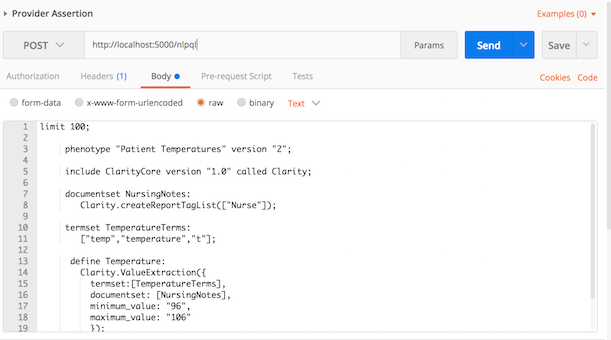

If you are unfamiliar with using tools such as Postman, you can submit NLPQL via the ClarityNLP user interface running in a web browser. For local instances, this will be at [localhost:8200/runner](localhost:8200/runner). 

![NLPQL_Runner.png](assets/NLPQL_Runner.png)
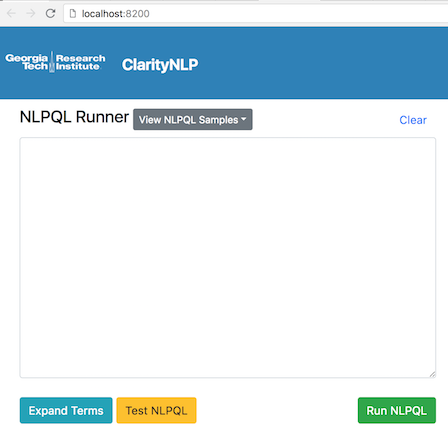

If you wish to run NLPQL directly from this notebook, then please use the following code.  You will need to edit the `url` variable to "localhost:5000/" or your ClarityNLP server IP address.

In [63]:
# This code below is only required for running ClarityNLP in Jupyter notebooks. It is not required if running NLPQL via API or the ClarityNLP GUI.

import json, csv
import urllib, requests
import pandas as pd

url = 'http://18.220.133.76:5000/'
nlpql_url = url + 'nlpql'
expander_url = url + 'nlpql_expander'
tester_url = url + 'nlpql_tester'

In [87]:
def run_nlpql(nlpql):
    re = requests.post(nlpql_url, data=nlpql, headers={'content-type':'text/plain'})
    global run_result
    global main_csv
    global intermediate_csv
    global luigi
    
    if re.ok:
        run_result = re.json()
        main_csv = run_result['main_results_csv']
        intermediate_csv = run_result['intermediate_results_csv']
        luigi = run_result['luigi_task_monitoring']
        print("Job Successfully Submitted")
        print(json.dumps(run_result, indent=4, sort_keys=True))


Note: Throughout these tutorials, we will prepend all examples with `limit 100;`.  This limits the server to analyzing a maxium of 100 documents, reducing runtime and compute load when testing new queries. Once a query is producing the expected output, removing this line will allow the full dataset to be run.

## Case #1: Congestive Heart Failure
For this first use case, our goal is to find patients with reduced ejection fraction and/or late stage CHF who are experiencing symptomatic orthopnea.  We will begin by breaking this into smaller components then combining into a comprehensive phenotype definition that can be shared across sites.

### 1.1 Find mentions of "Orthopnea" in the patient chart.

We will start with a basic example, simply looking for the presence of a given term in the record.
```java
limit 100;

//phenotype name
phenotype "Orthopnea" version "2";

//include Clarity main NLP libraries
include ClarityCore version "1.0" called Clarity;

termset Orthopnea:
  ["orthopnea","orthopnoea"];

define hasOrthopnea:
  Clarity.TermFinder({
    termset:[Orthopnea]
    });
```

To run this NLPQL, copy/paste the above and submit via API or the ClarityNLP interface.  Or if you would like to run the NLPQL directoly within this notebook, run the code below.

In [83]:
# Sample NLPQL
nlpql ='''
limit 10;

//phenotype name
phenotype "Orthopnea" version "2";

//include Clarity main NLP libraries
include ClarityCore version "1.0" called Clarity;

termset Orthopnea:
  ["orthopnea","orthopnoea"];

define hasOrthopnea:
  Clarity.TermFinder({
    termset:[Orthopnea]
    });
'''
run_nlpql(nlpql)

Job Successfully Submitted
{
    "intermediate_results_csv": "http://18.220.133.76:5000/job_results/307/phenotype_intermediate",
    "job_id": "307",
    "luigi_task_monitoring": "http://18.220.133.76:8082/static/visualiser/index.html#search__search=job=307",
    "main_results_csv": "http://18.220.133.76:5000/job_results/307/phenotype",
    "phenotype_config": "http://18.220.133.76:5000/phenotype_id/307",
    "phenotype_id": "307",
    "pipeline_configs": [
        "http://18.220.133.76:5000/pipeline_id/479"
    ],
    "pipeline_ids": [
        479
    ],
    "results_viewer": "?job=307",
    "status_endpoint": "http://18.220.133.76:5000/status/307"
}


### Job Monitoring

Small jobs with limits such as that above typically take less than 60 seconds to run.  Bigger jobs can take much (much) longer.  You can view your job's progress and see how ClarityNLP has broken up the query using the [Luigi Status Monitor](http://18.220.133.76:8082/static/visualiser/index.html).  Here is a screenshot of the above query running in Luigi.

![Screen%20Shot%202018-08-28%20at%2010.27.36%20PM.png](assets/Luigi.png)
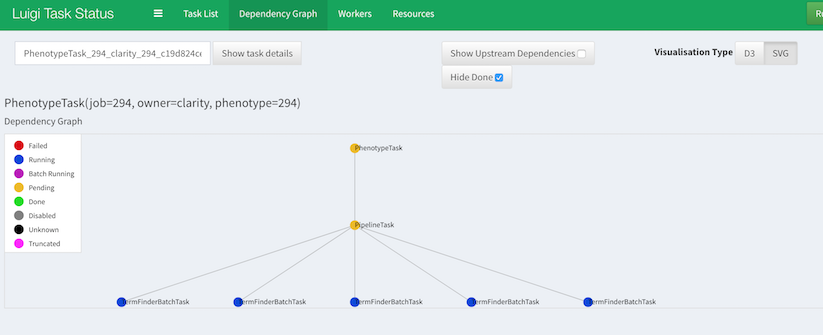

### Viewing Results
There are two types of results from an NLPQL query: intermediate results and final results.  *Intermediate results* refer to all data that are extracted by the query.  *Final results* refer to only those patients or documents meeting a specified logic (eg. cohort criteria).  

For the current task, we have not defined a cohort logic.  We asked only to find mentions of orthopnea, which is a data extraction task and will produce only intermediate results.  To download the intermediate results, you can navigate to the `intermediate_results_csv` URL returned by your API call or if you used this notebook, you can see tne URL and a preview below.

In [73]:
print(intermediate_csv)

http://18.220.133.76:5000/job_results/300/phenotype_intermediate


In [70]:
inter_csv_df = pd.read_csv(intermediate_csv)
inter_csv_df.head()

,_id,batch,concept_code,end,experiencer,inserted_date,job_id,negation,nlpql_feature,owner,...,report_id,report_type,section,sentence,solr_id,source,start,subject,temporality,term
0,5b8609d5d982be0ca4e3d549,0,-1,95,Patient,2018-08-29 02:49:57.706000,300,Affirmed,hasOrthopnea,clarity,...,1079230,Radiology,UNKNOWN,Clip # [**Clip Number (Radiology) 35135**] Rea...,1079230,MIMIC,86,54604,Recent,orthopnea
1,5b8609d5d982be0ca4e3d54a,0,-1,32,Patient,2018-08-29 02:49:57.710000,300,Affirmed,hasOrthopnea,clarity,...,1079230,Radiology,CONDITION,72 year old woman with orthopnea REASON FOR THIS,1079230,MIMIC,23,54604,Recent,orthopnea
2,5b8609d5d982be0ca4e3d54b,0,-1,44,Patient,2018-08-29 02:49:57.711000,300,Affirmed,hasOrthopnea,clarity,...,1079230,Radiology,PHYSICAL_EXAMINATION,pls eval for chf or other cause of orthopnea F...,1079230,MIMIC,35,54604,Recent,orthopnea
3,5b8609d5d982be0ca4e3d54c,0,-1,9,Patient,2018-08-29 02:49:57.711000,300,Affirmed,hasOrthopnea,clarity,...,1079230,Radiology,HISTORY_PRESENT_ILLNESS,Orthopnea.,1079230,MIMIC,0,54604,Recent,Orthopnea
4,5b8609d5d982be0ca4e3d54d,0,-1,70,Patient,2018-08-29 02:49:57.910000,300,Affirmed,hasOrthopnea,clarity,...,769966,Radiology,UNKNOWN,Clip # [**Clip Number (Radiology) 13510**] Rea...,769966,MIMIC,61,17456,Recent,orthopnea


Looking at the results, you may notice that the `TermFinder` function peforms a picks up both negated and affirmed cases as well as historical, hypothetical, and any other mentions.  TermFinder can be tuned to pull only specific results. Such as in the example below, which only gets positive mentions.

```java
limit 100;

//phenotype name
phenotype "Orthopnea" version "2";

//include Clarity main NLP libraries
include ClarityCore version "1.0" called Clarity;

termset Orthopnea:
  ["orthopnea","orthopnoea"];

define hasOrthopnea:
  Clarity.TermFinder({
    termset:[Orthopnea],
    negated:"Affirmed"
    });
```

In [84]:
# Sample NLPQL
nlpql ='''
limit 100;

//phenotype name
phenotype "Orthopnea" version "2";

//include Clarity main NLP libraries
include ClarityCore version "1.0" called Clarity;

termset Orthopnea:
  ["orthopnea","orthopnoea"];

define hasOrthopnea:
  Clarity.TermFinder({
    termset:[Orthopnea],
    negated:"Affirmed"
    });
'''
run_nlpql(nlpql)

Job Successfully Submitted


Because many term searchers are actually looking for non-negated, non-hypothetical, subject=patient mentions, we provide a convenient function `ProviderAssertion` to capture those mentions without needing to configure TermFinder. 

```java
limit 100;

//phenotype name
phenotype "Orthopnea" version "2";

//include Clarity main NLP libraries
include ClarityCore version "1.0" called Clarity;

termset Orthopnea:
  ["orthopnea","orthopnoea"];

define hasOrthopnea:
  Clarity.ProviderAssertion({
    termset:[Orthopnea]
    });
```

### 1.2 Find NYHA Class III/IV patients or those with EF<30%
For the next component of this tutorial, we will aim to extract specific values about CHF from the chart.  This is commonly done with the [ValueExtraction](https://claritynlp.readthedocs.io/en/latest/developer_guide/algorithms/value_extraction.html) function.  Value extractions can be numeric as well as an enumerated list of values.

In this example, we will be searching for ejection fraction values using a very simple algorithm.  Specifically, we will be looking for certain terms and subsequent values that would be typical for EF values.  (There are many more sophisticated methods to find ejection fraction (e.g [Kim et al](https://www.ncbi.nlm.nih.gov/pubmed/28163196)).)  We will then constrain the "final" cohort to only those with an EF < 30.

```java
limit 100;
//phenotype name
phenotype "Ejection Fraction Values" version "1";

//include Clarity main NLP libraries
include ClarityCore version "1.0" called Clarity;

termset EjectionFractionTerms:
  ["ef","ejection fraction","lvef"];

define EjectionFraction:
  Clarity.ValueExtraction({
    termset:[EjectionFractionTerms],
    minimum_value: "10",
    maximum_value: "85"
    });

//logical Context (Patient, Document)
context Patient;

define final LowEFPatient:
    where EjectionFraction.value <= 30;
```


In [90]:
# Sample NLPQL
nlpql ='''
limit 100;
//phenotype name
phenotype "Ejection Fraction Values" version "1";

//include Clarity main NLP libraries
include ClarityCore version "1.0" called Clarity;

termset EjectionFractionTerms:
  ["ef","ejection fraction","lvef"];

define EjectionFraction:
  Clarity.ValueExtraction({
    termset:[EjectionFractionTerms],
    minimum_value: "10",
    maximum_value: "85"
    });

//logical Context (Patient, Document)
context Patient;

define final LowEFPatient:
    where EjectionFraction.value <= 30;
'''
run_nlpql(nlpql)

Job Successfully Submitted
{
    "intermediate_results_csv": "http://18.220.133.76:5000/job_results/314/phenotype_intermediate",
    "job_id": "314",
    "luigi_task_monitoring": "http://18.220.133.76:8082/static/visualiser/index.html#search__search=job=314",
    "main_results_csv": "http://18.220.133.76:5000/job_results/314/phenotype",
    "phenotype_config": "http://18.220.133.76:5000/phenotype_id/314",
    "phenotype_id": "314",
    "pipeline_configs": [
        "http://18.220.133.76:5000/pipeline_id/486"
    ],
    "pipeline_ids": [
        486
    ],
    "results_viewer": "?job=314",
    "status_endpoint": "http://18.220.133.76:5000/status/314"
}


The `final` declaration refers to a cohort definition and typically involves some logic.  So in this case we defined an extraction process to pull all values between 10 and 85 following EF, LVEF, etc.  We then specified a `context`, meaning that the logic should operate on the level of a patient.  (The other option is Document context, which we will describe in a future session.)  Our logical rule stated that patients with an EjectionFraction <= 30 would make our criteria for a Low EF Patient. 

Results can be found at the main_results_csv URL from your API response, or if  you ran here in this notebook:

In [91]:
print(main_csv)

http://18.220.133.76:5000/job_results/314/phenotype


In [92]:
final_csv_df = pd.read_csv(main_csv)
final_csv_df.head()

,_id,batch,concept_code,condition,context_type,dimension_X,dimension_Y,dimension_Z,end,inserted_date,...,source,start,subject,temporality,term,text,units,value,value1,value2
0,5b861463d982be111ec73acc,25,-1,EQUAL,subject,15.0,-1.0,NaN,23,2018-08-29 03:34:48.927000,...,MIMIC,0,28785,NaN,NaN,Ejection fraction,NaN,15.0,NaN,NaN
1,5b861463d982be111ec73acd,25,-1,EQUAL,subject,20.0,-1.0,NaN,74,2018-08-29 03:34:49.370000,...,MIMIC,66,57911,NaN,NaN,LVEF,NaN,20.0,NaN,NaN
2,5b861463d982be111ec73ace,25,-1,APPROX,subject,30.0,-1.0,NaN,58,2018-08-29 03:34:49.566000,...,MIMIC,21,68579,NaN,NaN,ejection fraction,NaN,30.0,NaN,NaN
3,5b861463d982be111ec73acf,25,-1,EQUAL,subject,20.0,-1.0,NaN,126,2018-08-29 03:34:49.628000,...,MIMIC,116,1944,NaN,NaN,LVEF,NaN,20.0,NaN,NaN
4,5b861463d982be111ec73ad0,25,-1,EQUAL,subject,20.0,-1.0,NaN,127,2018-08-29 03:34:49.629000,...,MIMIC,104,1944,NaN,NaN,ejection fraction,NaN,20.0,NaN,NaN


The next step is to use ValueExtraction to pull out an enumerated value set (rather than a quantitative value).  See the example below for NYHA class.

```java
limit 100;
//phenotype name
phenotype "NYHA Class" version "1";

//include Clarity  main NLP libraries
include ClarityCore version "1.0" called Clarity;

termset NYHATerms:
  ["nyha"];

define NYHAClass:
  Clarity.ValueExtraction({
    termset:[NYHATerms],
    enum_list: ["3","4","iii","iv"];
    });
```

In [93]:
# Sample NLPQL
nlpql ='''
limit 100;
//phenotype name
phenotype "NYHA Class" version "1";

//include Clarity  main NLP libraries
include ClarityCore version "1.0" called Clarity;

termset NYHATerms:
  ["nyha"];

define NYHAClass:
  Clarity.ValueExtraction({
    termset:[NYHATerms],
    enum_list: ["3","4","iii","iv"];
    });
'''
run_nlpql(nlpql)

Job Successfully Submitted
{
    "intermediate_results_csv": "http://18.220.133.76:5000/job_results/315/phenotype_intermediate",
    "job_id": "315",
    "luigi_task_monitoring": "http://18.220.133.76:8082/static/visualiser/index.html#search__search=job=315",
    "main_results_csv": "http://18.220.133.76:5000/job_results/315/phenotype",
    "phenotype_config": "http://18.220.133.76:5000/phenotype_id/315",
    "phenotype_id": "315",
    "pipeline_configs": [
        "http://18.220.133.76:5000/pipeline_id/487"
    ],
    "pipeline_ids": [
        487
    ],
    "results_viewer": "?job=315",
    "status_endpoint": "http://18.220.133.76:5000/status/315"
}


In [94]:
# view intermediate results
inter_csv_df = pd.read_csv(intermediate_csv)
inter_csv_df.head()

,_id,batch,concept_code,condition,dimension_X,dimension_Y,dimension_Z,end,inserted_date,job_id,...,source,start,subject,temporality,term,text,units,value,value1,value2
0,5b86179b2d766700725ffa55,75,-1,EQUAL,iii,-1,NaN,266,2018-08-29 03:48:43.050000,315,...,MIMIC,249,9547,NaN,NaN,NYHA,NaN,iii,NaN,NaN
1,5b86179b2d766700725ffa56,75,-1,EQUAL,iii,-1,NaN,35,2018-08-29 03:48:43.055000,315,...,MIMIC,18,9547,NaN,NaN,NYHA,NaN,iii,NaN,NaN
2,5b86179c2d766700725ffa57,75,-1,EQUAL,iii,-1,NaN,26,2018-08-29 03:48:44.081000,315,...,MIMIC,5,32158,NaN,NaN,NYHA,NaN,iii,NaN,NaN
3,5b86179c2d766700725ffa58,75,-1,EQUAL,iii,-1,NaN,52,2018-08-29 03:48:44.448000,315,...,MIMIC,24,90546,NaN,NaN,NYHA,NaN,iii,NaN,NaN
4,5b86179c2d766700725ffa59,75,-1,EQUAL,iii,-1,NaN,52,2018-08-29 03:48:44.449000,315,...,MIMIC,24,90546,NaN,NaN,NYHA,NaN,iii,NaN,NaN


### 1.3 Bringing the criteria together to find the target CHF cohort

For the final step in example 1, we want to bring together the above criteria to generate our final cohort.

```java
limit 100;
//phenotype name
phenotype "NYHA Class" version "1";

//include Clarity  main NLP libraries
include ClarityCore version "1.0" called Clarity;

//termsets
termset Orthopnea:
  ["orthopnea","orthopnoea"];

termset EjectionFractionTerms:
  ["ef","ejection fraction","lvef"];

termset NYHATerms:
  ["nyha"];

//data extractions
define hasOrthopnea:
  Clarity.ProviderAssertion({
    termset:[Orthopnea]
    });

define EjectionFraction:
  Clarity.ValueExtraction({
    termset:[EjectionFractionTerms],
    minimum_value: "10",
    maximum_value: "85"
    });


define NYHAClass34:
  Clarity.ValueExtraction({
    termset:[NYHATerms],
    enum_list: ["3","4","iii","iv"];
    });

//logical context (Patient, Document)
context Patient;

define LowEF:
    where EjectionFraction.value <= 30;

define SevereCHF:
    where NYHAClass34 OR LowEF;
    
define final SevereCHFwithOrthopnea:
    where SevereCHF AND hasOrthopnea;
```

In [95]:
# Sample NLPQL
nlpql ='''
limit 100;
//phenotype name
phenotype "Final CHF Cohort" version "1";

//include Clarity  main NLP libraries
include ClarityCore version "1.0" called Clarity;

//termsets
termset Orthopnea:
  ["orthopnea","orthopnoea"];

termset EjectionFractionTerms:
  ["ef","ejection fraction","lvef"];

termset NYHATerms:
  ["nyha"];

//data extractions
define hasOrthopnea:
  Clarity.ProviderAssertion({
    termset:[Orthopnea]
    });

define EjectionFraction:
  Clarity.ValueExtraction({
    termset:[EjectionFractionTerms],
    minimum_value: "10",
    maximum_value: "85"
    });


define NYHAClass34:
  Clarity.ValueExtraction({
    termset:[NYHATerms],
    enum_list: ["3","4","iii","iv"];
    });

//logical context (Patient, Document)
context Patient;

define LowEF:
    where EjectionFraction.value <= 30;

define SevereCHF:
    where NYHAClass34 OR LowEF;
    
define final SevereCHFwithOrthopnea:
    where SevereCHF AND hasOrthopnea;
'''
run_nlpql(nlpql)

Job Successfully Submitted
{
    "intermediate_results_csv": "http://18.220.133.76:5000/job_results/321/phenotype_intermediate",
    "job_id": "321",
    "luigi_task_monitoring": "http://18.220.133.76:8082/static/visualiser/index.html#search__search=job=321",
    "main_results_csv": "http://18.220.133.76:5000/job_results/321/phenotype",
    "phenotype_config": "http://18.220.133.76:5000/phenotype_id/321",
    "phenotype_id": "321",
    "pipeline_configs": [
        "http://18.220.133.76:5000/pipeline_id/499",
        "http://18.220.133.76:5000/pipeline_id/500",
        "http://18.220.133.76:5000/pipeline_id/501"
    ],
    "pipeline_ids": [
        499,
        500,
        501
    ],
    "results_viewer": "?job=321",
    "status_endpoint": "http://18.220.133.76:5000/status/321"
}


In [96]:
final_csv_df = pd.read_csv(main_csv)
final_csv_df.head()

,_id,_id_x,_id_y,context_type,job_date,job_id,nlpql_feature,nlpql_feature_x,nlpql_feature_y,owner,phenotype_final,phenotype_id,raw_definition_text,report_date_x,report_date_y,report_id_x,report_id_y,sentence_x,sentence_y,subject
0,5b86a0de2d766709fcba2a83,5b86a0de2d766709fcba2a73,5b86a0da2d766709e3ba29a5,subject,2018-08-29 13:34:22.295000,321,SevereCHFwithOrthopnea,SevereCHF,hasOrthopnea,321,True,321,SevereCHF AND hasOrthopnea,2195-08-21T00:00:00Z,2195-10-16T00:00:00Z,86213,1156997,The left ventricular ejection fraction is appr...,"64 year old man with DOE, orthopnea, h/o CHF R...",68579
1,5b86a0de2d766709fcba2a84,5b86a0de2d766709fcba2a73,5b86a0da2d766709e3ba29a6,subject,2018-08-29 13:34:22.295000,321,SevereCHFwithOrthopnea,SevereCHF,hasOrthopnea,321,True,321,SevereCHF AND hasOrthopnea,2195-08-21T00:00:00Z,2195-10-16T00:00:00Z,86213,1156997,The left ventricular ejection fraction is appr...,"Dyspnea on exertion, orthopnea, history of CHF...",68579


In the above case, we may need to increase our limit beyond 100 documents to find many matching patients, because multiple criteria are required and a small sample may not be enough.  Try increasing to 500 documents.

### Reviewing Results through the ClarityNLP UI
Downloading the raw CSV results is handy for analysis and data manipulation.  However, a domain-oriented end user may be more interested in just exploring and validating the final results without getting into all the programmatic details.  That's where the Results Viewer comes in, which in a typical installation will be found at localhost:8200/


![Screen%20Shot%202018-08-29%20at%209.33.35%20AM.png](assets/Clarity Validator.png)
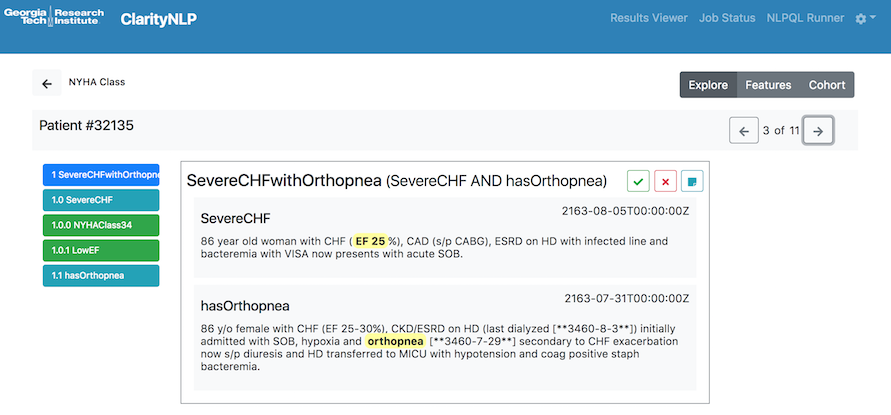

## Case #2: Capturing Information on Patient Race
Although there are many useful [core algorithms](https://claritynlp.readthedocs.io/en/latest/developer_guide/index.html#task-algorithms) in ClarityNLP, users will frequently want to extend its functionality.  In this second example, we will explore how to extend ClarityNLP when the built in algorithms are inadequate.  

In this case, we'd like to identify the patient's race.  While some version of this could probably we done with simple search terms, a custom algorithm will likely be necessary.  Below is an example of a custom Python algorithm written to extract race information from a document. 

```python

str_sep = r'(\s-\s|-\s|\s-|\s)'
str_word = r'\b[-a-z.\d]+'
str_punct = r'[,.\s]*'
str_words = r'(' + str_word + str_punct + r'){0,6}'
str_person = r'\b(gentleman|gentlewoman|male|female|man|woman|person|'    +\
             r'child|boy|girl|infant|baby|newborn|neonate|individual)\b'
str_category = r'\b(american' + str_sep + r'indian|'                      +\
               r'alaska' + str_sep + r'native|asian|'                     +\
               r'african' + str_sep + r'american|black|negro|'            +\
               r'native' + str_sep + r'hawaiian|'                         +\
               r'other' + str_sep + r'pacific' + str_sep + r'islander|'   +\
               r'pacific' + str_sep + r'islander|'                        +\
               r'native' + str_sep + r'american|'                         +\
               r'white|caucasian|european)'

str_race1 = r'(\brace:?\s*)' + r'(?P<category>' + str_category + r')'
regex_race1 = re.compile(str_race1, re.IGNORECASE)
str_race2 = r'(?P<category>' + str_category + r')' + str_punct    +\
            str_words + str_person
regex_race2 = re.compile(str_race2, re.IGNORECASE)
str_race3 = str_person + str_punct + str_words + r'(?P<category>' +\
            str_category + r')'
regex_race3 = re.compile(str_race3, re.IGNORECASE)
REGEXES = [regex_race1, regex_race2, regex_race3]

RACE_FINDER_RESULT_FIELDS = ['sentence_index', 'start', 'end', 'race',
                             'normalized_race']
RaceFinderResult = namedtuple('RaceFinderResult', RACE_FINDER_RESULT_FIELDS)


###############################################################################
def normalize(race_text):
    """
    Convert a matching race string to a 'normalized' version.
    """

    NORM_MAP = {
        'african american':'black',
        'negro':'black',
        'caucasian':'white',
        'european':'white',
    }
    
    # convert to lowercase, remove dashes, collapse repeated whitespace
    race = race_text.lower()
    race = re.sub(r'[-]+', '', race)
    race = re.sub(r'\s+', ' ', race)

    if race in NORM_MAP:
        return NORM_MAP[race]
    else:
        return race
    

###############################################################################
def find_race(sentence_list):
    """
    Scan a list of sentences and run race-finding regexes on each.
    Return a dict that maps sentence_index -> race_category.
    """

    result_list = []

    found_match = False
    for i in range(len(sentence_list)):
        s = sentence_list[i]
        for regex in REGEXES:
            match = regex.search(s)
            if match:
                match_text = match.group('category')
                start = match.start()
                end   = match.end()
                normalized = normalize(match_text)
                result = RaceFinderResult(i, start, end, match_text, normalized)
                result_list.append(result)
                found_match = True
                break

        # Reports are unlikely to have more than one sentence stating the
        # patient's race.
        if found_match:
            break
            
    return result_list
```

Without going into the details, this algorithm parses text to find race information, normalizes it to standard terms, and passes back the result.  In order to run this algorithm using NLPQL in ClarityNLP, we create what is called a custom task.  Below is code that creates the CustomTask wrapping this function and provides it with the documents and handling of result ouput.

```python
# use this name in NLPQL
    task_name = "RaceFinderTask"

    def run_custom_task(self, temp_file, mongo_client: MongoClient):

        # for each document in the NLPQL-specified doc set
        for doc in self.docs:

            # all sentences in this document
            sentence_list = self.get_document_sentences(doc)

            # all race results in this document
            result_list = find_race(sentence_list)
                
            if len(result_list) > 0:
                for result in result_list:
                    obj = {
                        'sentence':sentence_list[result.sentence_index],
                        'start':result.start,
                        'end':result.end,
                        'value':result.race,
                        'value_normalized':result.normalized_race,
                    }
            
                    self.write_result_data(temp_file, mongo_client, doc, obj)
                    ```

These files can be split into two or can be combined as shown in the final custom task below.

In [98]:
import re
from pymongo import MongoClient
from collections import namedtuple
from tasks.task_utilities import BaseTask

str_sep = r'(\s-\s|-\s|\s-|\s)'
str_word = r'\b[-a-z.\d]+'
str_punct = r'[,.\s]*'
str_words = r'(' + str_word + str_punct + r'){0,6}'
str_person = r'\b(gentleman|gentlewoman|male|female|man|woman|person|'    +\
             r'child|boy|girl|infant|baby|newborn|neonate|individual)\b'
str_category = r'\b(american' + str_sep + r'indian|'                      +\
               r'alaska' + str_sep + r'native|asian|'                     +\
               r'african' + str_sep + r'american|black|negro|'            +\
               r'native' + str_sep + r'hawaiian|'                         +\
               r'other' + str_sep + r'pacific' + str_sep + r'islander|'   +\
               r'pacific' + str_sep + r'islander|'                        +\
               r'native' + str_sep + r'american|'                         +\
               r'white|caucasian|european)'

str_race1 = r'(\brace:?\s*)' + r'(?P<category>' + str_category + r')'
regex_race1 = re.compile(str_race1, re.IGNORECASE)
str_race2 = r'(?P<category>' + str_category + r')' + str_punct    +\
            str_words + str_person
regex_race2 = re.compile(str_race2, re.IGNORECASE)
str_race3 = str_person + str_punct + str_words + r'(?P<category>' +\
            str_category + r')'
regex_race3 = re.compile(str_race3, re.IGNORECASE)
REGEXES = [regex_race1, regex_race2, regex_race3]

RACE_FINDER_RESULT_FIELDS = ['sentence_index', 'start', 'end', 'race',
                             'normalized_race']
RaceFinderResult = namedtuple('RaceFinderResult', RACE_FINDER_RESULT_FIELDS)


###############################################################################
def normalize(race_text):
    """
    Convert a matching race string to a 'normalized' version.
    """

    NORM_MAP = {
        'african american':'black',
        'negro':'black',
        'caucasian':'white',
        'european':'white',
    }
    
    # convert to lowercase, remove dashes, collapse repeated whitespace
    race = race_text.lower()
    race = re.sub(r'[-]+', '', race)
    race = re.sub(r'\s+', ' ', race)

    if race in NORM_MAP:
        return NORM_MAP[race]
    else:
        return race
    

###############################################################################
def find_race(sentence_list):
    """
    Scan a list of sentences and run race-finding regexes on each.
    Return a dict that maps sentence_index -> race_category.
    """

    result_list = []

    found_match = False
    for i in range(len(sentence_list)):
        s = sentence_list[i]
        for regex in REGEXES:
            match = regex.search(s)
            if match:
                match_text = match.group('category')
                start = match.start()
                end   = match.end()
                normalized = normalize(match_text)
                result = RaceFinderResult(i, start, end, match_text, normalized)
                result_list.append(result)
                found_match = True
                break

        # Reports are unlikely to have more than one sentence stating the
        # patient's race.
        if found_match:
            break
            
    return result_list


###############################################################################
class RaceFinderTask(BaseTask):
    """
    A custom task for finding a patient's race.
    """
    
    # use this name in NLPQL
    task_name = "RaceFinderTask"

    def run_custom_task(self, temp_file, mongo_client: MongoClient):

        # for each document in the NLPQL-specified doc set
        for doc in self.docs:

            # all sentences in this document
            sentence_list = self.get_document_sentences(doc)

            # all race results in this document
            result_list = find_race(sentence_list)
                
            if len(result_list) > 0:
                for result in result_list:
                    obj = {
                        'sentence':sentence_list[result.sentence_index],
                        'start':result.start,
                        'end':result.end,
                        'value':result.race,
                        'value_normalized':result.normalized_race,
                    }
            
                    self.write_result_data(temp_file, mongo_client, doc, obj)



ModuleNotFoundError: No module named 'pymongo'

This race task can be called in NLPQL as follows:

```java
    limit 100;

    phenotype "Race Finder" version "1";
    include ClarityCore version "1.0" called Clarity;

    documentset DischargeSummaries:
        Clarity.createReportTagList(["Discharge Summary"]);

    define RaceFinderFunction:
        Clarity.RaceFinderTask({
            documentset: [DischargeSummaries]
        });
```

Note:  This example is our first time using `documentset`, which allows us to specify a targeted list of documents such as Discharge Summaries or Radiology notes etc.  We will cover this is greater detail in future Cooking sessions. 

In [99]:
nlpql ='''
limit 100;

phenotype "Race Finder" version "1";
include ClarityCore version "1.0" called Clarity;

documentset DischargeSummaries:
    Clarity.createReportTagList(["Discharge Summary"]);

define RaceFinderFunction:
    Clarity.RaceFinderTask({
        documentset: [DischargeSummaries]
    });
'''
run_nlpql(nlpql)

Job Successfully Submitted
{
    "intermediate_results_csv": "http://18.220.133.76:5000/job_results/322/phenotype_intermediate",
    "job_id": "322",
    "luigi_task_monitoring": "http://18.220.133.76:8082/static/visualiser/index.html#search__search=job=322",
    "main_results_csv": "http://18.220.133.76:5000/job_results/322/phenotype",
    "phenotype_config": "http://18.220.133.76:5000/phenotype_id/322",
    "phenotype_id": "322",
    "pipeline_configs": [
        "http://18.220.133.76:5000/pipeline_id/502"
    ],
    "pipeline_ids": [
        502
    ],
    "results_viewer": "?job=322",
    "status_endpoint": "http://18.220.133.76:5000/status/322"
}


In [100]:
# view intermediate results
inter_csv_df = pd.read_csv(intermediate_csv)
inter_csv_df.head()

,_id,batch,concept_code,end,inserted_date,job_id,nlpql_feature,owner,phenotype_final,pipeline_id,...,report_date,report_id,report_type,sentence,solr_id,source,start,subject,value,value_normalized
0,5b86a5fc2d76670a1377c786,75,-1,23,2018-08-29 13:56:12.628000,322,RaceFinderFunction,clarity,False,502,...,2106-07-16T00:00:00Z,10851,Discharge summary,Overweight white female.,10851,MIMIC,11,11350,white,white
1,5b86a6002d76670a1977c786,25,-1,37,2018-08-29 13:56:16.440000,322,RaceFinderFunction,clarity,False,502,...,2106-05-03T00:00:00Z,8534,Discharge summary,Patient is a 46-year-old white female with his...,8534,MIMIC,25,15160,white,white
2,5b86a60a2d76670a1677c786,50,-1,54,2018-08-29 13:56:26.021000,322,RaceFinderFunction,clarity,False,502,...,2152-03-14T00:00:00Z,10838,Discharge summary,"In general, the patient was a middle-aged whit...",10838,MIMIC,42,26693,white,white
3,5b86a60c2d76670a1377c787,75,-1,27,2018-08-29 13:56:28.023000,322,RaceFinderFunction,clarity,False,502,...,2187-05-10T00:00:00Z,10862,Discharge summary,Elderly caucasian gentleman with Parkinsonian ...,10862,MIMIC,8,1819,caucasian,white
4,5b86a60d2d76670a1377c788,75,-1,362,2018-08-29 13:56:29.182000,322,RaceFinderFunction,clarity,False,502,...,2100-10-19T00:00:00Z,10863,Discharge summary,Past Medical History: Hyperchol HTN Afib with ...,10863,MIMIC,347,25436,caucasian,white


### 2.2 Combining race with other criteria

As you probably gathered, you can now write NLPQL that will look for all patients matching our CHF criteria with the race information extracted above.  The NLPQL would look like this:

```java
limit 100;
//phenotype name
phenotype "NYHA Class" version "1";

//include Clarity  main NLP libraries
include ClarityCore version "1.0" called Clarity;

//termsets
termset Orthopnea:
  ["orthopnea","orthopnoea"];

termset EjectionFractionTerms:
  ["ef","ejection fraction","lvef"];

termset NYHATerms:
  ["nyha"];


//documentsets
documentset DischargeSummaries:
    Clarity.createReportTagList(["Discharge Summary"]);


//data extractions
define hasOrthopnea:
  Clarity.ProviderAssertion({
    termset:[Orthopnea]
    });

define EjectionFraction:
  Clarity.ValueExtraction({
    termset:[EjectionFractionTerms],
    minimum_value: "10",
    maximum_value: "85"
    });


define NYHAClass34:
  Clarity.ValueExtraction({
    termset:[NYHATerms],
    enum_list: ["3","4","iii","iv"];
    });


define Race:
    Clarity.RaceFinderTask({
        documentset: [DischargeSummaries]
    });
       

//logical context (Patient, Document)
context Patient;

define LowEF:
    where EjectionFraction.value <= 30;

define SevereCHF:
    where NYHAClass34 OR LowEF;

define BlackRace:
    where Race.normalized_value = 'black';
    
define final SevereCHFwithOrthopnea:
    where SevereCHF AND hasOrthopnea;

define final BlackSevereCHFPatient:
    where SevereCHF AND BlackRace;
```
